In [564]:
import warnings
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from numpy import log
from datetime import date, datetime

warnings.filterwarnings("ignore")

#import sklearn
#sklearn.show_versions()
#sklearn.__version__
set_config(display='diagram')

In [522]:
import ray
import flaml

ray.__version__
flaml.__version__

'0.10.0'

In [583]:
data = pd.read_csv('data/train.csv', index_col=0)

In [584]:
calculate_road_neighbours(data)

(65, 3)


,easth_neighbour_road_id,north_neighbour_road_id,northeast_neighbour_road_id,northwest_neighbour_road_id,road_id,south_neighbour_road_id,southeast_neighbour_road_id,southwest_neighbour_road_id,west_neighbour_road_id
0,10WB,0-1SB,1-1SW,-1-1SE,00EB,01NB,11NW,-11NE,-10EB
1,10WB,0-1SB,1-1SW,-1-1SE,00NB,01NB,11NW,-11NE,-10EB
2,10WB,0-1SB,1-1SW,-1-1SE,00SB,01NB,11NW,-11NE,-10EB
3,11WB,00SB,10SW,-10SE,01EB,02NB,12NW,-12NE,-11EB
4,11WB,00SB,10SW,-10SE,01NB,02NB,12NW,-12NE,-11EB
...,...,...,...,...,...,...,...,...,...
60,33WB,22SB,32SW,12SE,23NB,24NB,34NW,14NE,13EB
61,33WB,22SB,32SW,12SE,23NE,24NB,34NW,14NE,13EB
62,33WB,22SB,32SW,12SE,23SB,24NB,34NW,14NE,13EB
63,33WB,22SB,32SW,12SE,23SW,24NB,34NW,14NE,13EB


In [585]:
# Add congestion information for previous timestamp, for the roads that lead to a given road
def calculate_road_neighbours(df):
    road_neighbours = pd.DataFrame()

    print(df[['x', 'y', 'direction']].drop_duplicates().shape)
    
    for _, road in df[['x', 'y', 'direction']].drop_duplicates().iterrows():
        north_neighbour_road_id     = str(road.x)     + str(road.y - 1) + 'SB'
        northeast_neighbour_road_id = str(road.x + 1) + str(road.y - 1) + "SW"
        easth_neighbour_road_id     = str(road.x + 1) + str(road.y)     + "WB"
        southeast_neighbour_road_id = str(road.x + 1) + str(road.y + 1) + "NW"
        south_neighbour_road_id     = str(road.x)     + str(road.y + 1) + "NB"
        southwest_neighbour_road_id = str(road.x - 1) + str(road.y + 1) + "NE"
        west_neighbour_road_id      = str(road.x - 1) + str(road.y)     + "EB"
        northwest_neighbour_road_id = str(road.x - 1) + str(road.y - 1) + "SE"

        road_neighbours = road_neighbours.append({"road_id": str(road.x) + str(road.y) + road.direction,
                                                  "north_neighbour_road_id": north_neighbour_road_id,
                                                  "northeast_neighbour_road_id": northeast_neighbour_road_id,
                                                  "easth_neighbour_road_id": easth_neighbour_road_id,
                                                  "southeast_neighbour_road_id": southeast_neighbour_road_id,
                                                  "south_neighbour_road_id": south_neighbour_road_id,
                                                  "southwest_neighbour_road_id": southwest_neighbour_road_id,
                                                  "west_neighbour_road_id": west_neighbour_road_id,
                                                  "northwest_neighbour_road_id": northwest_neighbour_road_id}, ignore_index = True)

    return road_neighbours

In [586]:
def feature_generation(data):

    # this is needed for the later part of the feature generation
    if 'congestion' not in data:
        data['congestion'] = np.nan
    
    data.time = pd.to_datetime(data.time)

    # data.loc[:, 'hour'] = data.time.dt.hour
    # data.loc[:, 'minute'] = data.time.dt.minute
    # data.loc[:, 'month'] = data.time.dt.month
    # data.loc[:, 'day'] = data.time.dt.day
    # data.loc[:, 'day_of_week'] = data.time.dt.dayofweek
    data.loc[:, 'is_weekend'] = data.time.dt.dayofweek >= 5

    start_date = pd.to_datetime(date(1991, 4, 1)) #where the dataset beggins
    data.loc[:, 'days_since_beg_of_time'] = [(a_date - start_date).days for a_date in data.time]

    n_minutes_1_day = 24*60
    data.loc[:, 'sin_time'] = np.sin(2*np.pi*(data.time.dt.hour * 60 + data.time.dt.minute)/n_minutes_1_day)
    data.loc[:, 'cos_time'] = np.cos(2*np.pi*(data.time.dt.hour * 60 + data.time.dt.minute)/n_minutes_1_day)

    data.loc[:, 'x_y'] = data['x'].astype(str) + "_" + data['y'].astype(str)
    data.loc[:, 'road_id'] = data['x'].astype(str) + data['y'].astype(str) + data['direction']
    
    congestion_wide = data.pivot(index = ['time'], columns = 'road_id', values = 'congestion')
    for shift in [1, 2, 3, 72, 504]: # lags: t-1, t-2, t-3, t=72 => 1 day, t=504 =>1 week
        shifted_data = congestion_wide.shift(shift).reset_index().melt(id_vars = ['time'])
        shifted_data.columns = ['time', 'road_id', f'congestion_t{shift}']
        data = data.merge(shifted_data, on = ['time', 'road_id'], how='left')
        
    # Generate features containing the congestion value in the previous timestamp, for the roads that end up in the sample road
    
    
    neighbour_roads = calculate_road_neighbours(data)
    neighbour_roads_columns = [c for c in neighbour_roads.columns if c != 'road_id']

    data = data.merge(neighbour_roads, on = 'road_id', how='left')

    congestion_t_minus1 = congestion_wide.shift(1).reset_index().melt(id_vars = ['time'])
    
    for c in neighbour_roads_columns:
        temp = congestion_t_minus1.copy()
        temp.columns = ['time', 'road_id', c.replace("road_id", "congestion_t1")]
        data = data.merge(temp, right_on = ["time", "road_id"], left_on = ["time", c], how = 'left')
        data = data.drop("road_id_y", axis = 1).rename(columns = {'road_id_x':"road_id"})
    
    data = data.drop(neighbour_roads_columns, axis = 1)
        
    features = data.columns
    return data, features

# scaler = MinMaxScaler()
data, features = feature_generation(data)
print(data.shape)
#data[features] = scaler.fit_transform(data[features])

data


(65, 3)
(848835, 24)


,time,x,y,direction,congestion,is_weekend,days_since_beg_of_time,sin_time,cos_time,x_y,...,congestion_t72,congestion_t504,easth_neighbour_congestion_t1,north_neighbour_congestion_t1,northeast_neighbour_congestion_t1,northwest_neighbour_congestion_t1,south_neighbour_congestion_t1,southeast_neighbour_congestion_t1,southwest_neighbour_congestion_t1,west_neighbour_congestion_t1
0,1991-04-01 00:00:00,0,0,EB,70,False,0,0.000000,1.000000,0_0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-04-01 00:00:00,0,0,NB,49,False,0,0.000000,1.000000,0_0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1991-04-01 00:00:00,0,0,SB,24,False,0,0.000000,1.000000,0_0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-04-01 00:00:00,0,1,EB,18,False,0,0.000000,1.000000,0_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1991-04-01 00:00:00,0,1,NB,60,False,0,0.000000,1.000000,0_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848830,1991-09-30 11:40:00,2,3,NB,54,False,182,0.087156,-0.996195,2_3,...,54.0,50.0,NaN,52.0,NaN,NaN,NaN,NaN,NaN,38.0
848831,1991-09-30 11:40:00,2,3,NE,28,False,182,0.087156,-0.996195,2_3,...,20.0,24.0,NaN,52.0,NaN,NaN,NaN,NaN,NaN,38.0
848832,1991-09-30 11:40:00,2,3,SB,68,False,182,0.087156,-0.996195,2_3,...,68.0,69.0,NaN,52.0,NaN,NaN,NaN,NaN,NaN,38.0
848833,1991-09-30 11:40:00,2,3,SW,17,False,182,0.087156,-0.996195,2_3,...,12.0,21.0,NaN,52.0,NaN,NaN,NaN,NaN,NaN,38.0


In [600]:
# this doesn't return anything
data[data['northwest_neighbour_congestion_t1'] > 10]

,time,x,y,direction,congestion,is_weekend,days_since_beg_of_time,sin_time,cos_time,x_y,...,congestion_t72,congestion_t504,easth_neighbour_congestion_t1,north_neighbour_congestion_t1,northeast_neighbour_congestion_t1,northwest_neighbour_congestion_t1,south_neighbour_congestion_t1,southeast_neighbour_congestion_t1,southwest_neighbour_congestion_t1,west_neighbour_congestion_t1


In [601]:
data.columns

Index(['time', 'x', 'y', 'direction', 'congestion', 'is_weekend',
       'days_since_beg_of_time', 'sin_time', 'cos_time', 'x_y', 'road_id',
       'congestion_t1', 'congestion_t2', 'congestion_t3', 'congestion_t72',
       'congestion_t504', 'easth_neighbour_congestion_t1',
       'north_neighbour_congestion_t1', 'northeast_neighbour_congestion_t1',
       'northwest_neighbour_congestion_t1', 'south_neighbour_congestion_t1',
       'southeast_neighbour_congestion_t1',
       'southwest_neighbour_congestion_t1', 'west_neighbour_congestion_t1'],
      dtype='object')

In [602]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
import lightgbm as lgb

# prepare the data
y = data.pop('congestion')
X = data

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [603]:
#!pip install flaml[notebook]
#!pip install --upgrade --force-reinstall flaml
#!pip install -U ray
#!pip install --upgrade --force-reinstall xgboost
#!pip install --upgrade xgboost
#pip install --upgrade azureml-automl-runtime
# starting_points = {}

In [611]:
from flaml import AutoML

automl = AutoML()

# 1 hour = 
# 

automl.fit(X,y, task="regression", time_budget=60*60*7, metric="mae", log_file_name='automl.log', estimator_list=['lgbm', 'rf', 'catboost', 'extra_tree'], eval_method='cv', n_splits=5, starting_points = starting_points, n_jobs=-1)
# xgb_limitdepth, xgboost

starting_points = automl.best_config_per_estimator

[flaml.automl: 03-25 00:53:01] {2068} INFO - task = regression
[flaml.automl: 03-25 00:53:01] {2070} INFO - Data split method: uniform
[flaml.automl: 03-25 00:53:01] {2074} INFO - Evaluation method: cv
[flaml.automl: 03-25 00:53:01] {2155} INFO - Minimizing error metric: mae
[flaml.automl: 03-25 00:53:01] {2248} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'extra_tree']
[flaml.automl: 03-25 00:53:02] {2501} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-25 01:01:32] {2617} INFO - Estimated sufficient time budget=5107804s. Estimated necessary time budget=10165s.
[flaml.automl: 03-25 01:01:32] {2669} INFO -  at 526.3s,	estimator lgbm's best error=5.6503,	best estimator lgbm's best error=5.6503
[flaml.automl: 03-25 01:01:32] {2501} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-25 01:09:02] {2669} INFO -  at 976.1s,	estimator lgbm's best error=5.6503,	best estimator lgbm's best error=5.6503
[flaml.automl: 03-25 01:09:02] {2501} INFO - iterat

In [612]:
#era: 5.5903
print("best estimator:", automl.best_estimator) 
print("best estimator config: ", automl.best_config)
print("best_config_per_estimator", automl.best_config_per_estimator)
print("best_loss_per_estimator", automl.best_loss_per_estimator)

best estimator: lgbm
best estimator config:  {'n_estimators': 9802, 'num_leaves': 1105, 'min_child_samples': 2, 'learning_rate': 0.012582786816629063, 'log_max_bin': 8, 'colsample_bytree': 0.5553795741704651, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.0009765625}
best_config_per_estimator {'lgbm': {'n_estimators': 9802, 'num_leaves': 1105, 'min_child_samples': 2, 'learning_rate': 0.012582786816629063, 'log_max_bin': 8, 'colsample_bytree': 0.5553795741704651, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.0009765625}, 'rf': {'n_estimators': 6, 'max_features': 0.6318169909508976, 'max_leaves': 5522}, 'catboost': {'early_stopping_rounds': 11, 'learning_rate': 0.0666110897556186, 'n_estimators': 245}, 'extra_tree': {'n_estimators': 26, 'max_features': 0.40667323558190555, 'max_leaves': 32767}}
best_loss_per_estimator {'lgbm': 5.482654846292062, 'rf': 6.102309747188222, 'catboost': 5.918687908250563, 'extra_tree': 5.849039748882881}


In [613]:
# Get predictions in a rolling fashion in order to get the previous timestamps -> we can get predictions in chunks of 65 samples (number of rows)
def generate_predictions_old(model, train_data, test_data):# all_data, timestamps_to_predict):
    
    output_data = pd.concat([train_data, test_data]).copy()
    timestamps_to_predict = test_data.time.unique()
    
    for timestamp in timestamps_to_predict:
        print(f"Predicting timestamp: {timestamp}")
        
        congestion_wide = output_data.pivot(index = ['time'], columns = 'road_id', values = 'congestion')
        for shift in [1, 2, 3, 72, 504]:
            shifted_data = congestion_wide.shift(shift).reset_index().melt(id_vars = ['time'])
            shifted_data.columns = ['time', 'road_id', f'congestion_t{shift}']
            output_data = output_data.drop(f'congestion_t{shift}', axis = 1)
            output_data = output_data.merge(shifted_data, on = ['time', 'road_id'], how = 'left')
        
        input_data = output_data[output_data.time == timestamp]
        predictions = model.predict(input_data)
        output_data.loc[input_data.index, 'congestion'] = predictions
    
    output_data
    
    test_predictions = output_data[output_data.time >= test_data.time.min()]
    #test_predictions = test_predictions[['congestion']].reset_index()
    #test_predictions.columns = ['row_id', 'congestion']
    #test_predictions['row_id'] = pd.read_csv("Data/sample_submission.csv")['row_id']
    
    return output_data, test_predictions


def generate_predictions(model, train_data, test_data):
    
    output_data = pd.concat([train_data, test_data]).copy()
    timestamps_to_predict = test_data.time.unique()
    
    neighbour_roads = calculate_road_neighbours(train_data)
    neighbour_roads_columns = [c for c in neighbour_roads.columns if c != 'road_id']
    
    for timestamp in timestamps_to_predict:
        print(f"Predicting timestamp: {timestamp}")
        
        congestion_wide = output_data.pivot(index = ['time'], columns = 'road_id', values = 'congestion')
        for shift in [1, 2, 3, 72, 504]:
            shifted_data = congestion_wide.shift(shift).reset_index().melt(id_vars = ['time'])
            shifted_data.columns = ['time', 'road_id', f'congestion_t{shift}']
            output_data = output_data.drop(f'congestion_t{shift}', axis = 1)
            output_data = output_data.merge(shifted_data, on = ['time', 'road_id'], how = 'left')
        
            output_data = output_data.merge(neighbour_roads, on = 'road_id', how = 'left')
            congestion_t_minus1 = congestion_wide.shift(1).reset_index().melt(id_vars = ['time'])

            for c in neighbour_roads_columns:
                temp = congestion_t_minus1.copy()
                temp.columns = ['time', 'road_id', c.replace("road_id", "congestion_t1")]
                output_data = output_data.drop(c.replace("road_id", "congestion_t1"), axis = 1)
                output_data = output_data.merge(temp, right_on = ["time", "road_id"], left_on = ["time", c], how = 'left')
                output_data = output_data.drop("road_id_y", axis = 1).rename(columns = {'road_id_x':"road_id"})

            output_data = output_data.drop(neighbour_roads_columns, axis = 1)
        
        input_data = output_data[output_data.time == timestamp]
        predictions = model.predict(input_data)
        output_data.loc[input_data.index, 'congestion'] = predictions
    
    test_predictions = output_data[output_data.time >= test_data.time.min()]
    return output_data, test_predictions

In [614]:
# holdout_pred

In [615]:
test_data = pd.read_csv('data/test.csv', index_col=0)

print(test_data.shape)
test_data, _ = feature_generation(test_data) # this messes up the index. it's not right.

print(test_data.shape)
all_data, holdout_pred = generate_predictions(automl, train_data, test_data)


temp = holdout_pred.sort_values(['time', 'x', 'y', 'direction'])

# fix hammer
test_data2 = pd.read_csv('data/test.csv', index_col=0)
temp.index = test_data2.index

temp['congestion'].to_csv("data/holdout_predictions.csv",  index_label = 'row_id')

#test_data = pd.read_csv('data/test.csv', index_col=0)
#test_data, _ = feature_generation(test_data)
#test_data
#holdout_pred = automl.predict(test_data)
#holdout_pred

(2340, 4)
(65, 3)
(2340, 24)
(65, 3)
Predicting timestamp: 1991-09-30T12:00:00.000000000
Predicting timestamp: 1991-09-30T12:20:00.000000000
Predicting timestamp: 1991-09-30T12:40:00.000000000
Predicting timestamp: 1991-09-30T13:00:00.000000000
Predicting timestamp: 1991-09-30T13:20:00.000000000
Predicting timestamp: 1991-09-30T13:40:00.000000000
Predicting timestamp: 1991-09-30T14:00:00.000000000
Predicting timestamp: 1991-09-30T14:20:00.000000000
Predicting timestamp: 1991-09-30T14:40:00.000000000
Predicting timestamp: 1991-09-30T15:00:00.000000000
Predicting timestamp: 1991-09-30T15:20:00.000000000
Predicting timestamp: 1991-09-30T15:40:00.000000000
Predicting timestamp: 1991-09-30T16:00:00.000000000
Predicting timestamp: 1991-09-30T16:20:00.000000000
Predicting timestamp: 1991-09-30T16:40:00.000000000
Predicting timestamp: 1991-09-30T17:00:00.000000000
Predicting timestamp: 1991-09-30T17:20:00.000000000
Predicting timestamp: 1991-09-30T17:40:00.000000000
Predicting timestamp: 1991-

In [ ]:
test_data.index

In [442]:
submission = holdout_pred['congestion']
submission.to_csv('data/holdout_predictions.csv', index_label = 'row_id')

In [443]:
# OLD CODE NO PROPER FEATURE AUGMENTATION

#test_data = pd.read_csv('data/test.csv', index_col=0)
#test_data, _ = feature_generation(test_data)
# OLD test_data = pd.DataFrame(scaler.transform(test_data), columns=features, index=test_data.index)
# OLD test_data = pd.DataFrame(test_data, columns=features, index=test_data.index)

# holdout_pred = automl.predict(test_data)

# test_data['congestion'] = holdout_pred #[:,1]
# submission = test_data['congestion']
# submission.to_csv('data/holdout_predictions.csv')
# OLD data_to_save.reset_index()
# OLD data_to_save.to_csv('data/holdout_predictions.csv', index=False)

In [616]:
from flaml.data import get_output_from_log

time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = get_output_from_log(filename='automl.log', time_budget=3600*8)

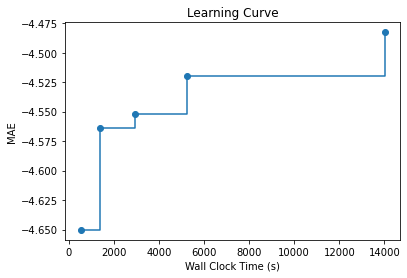

In [617]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('MAE')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

<BarContainer object of 29 artists>

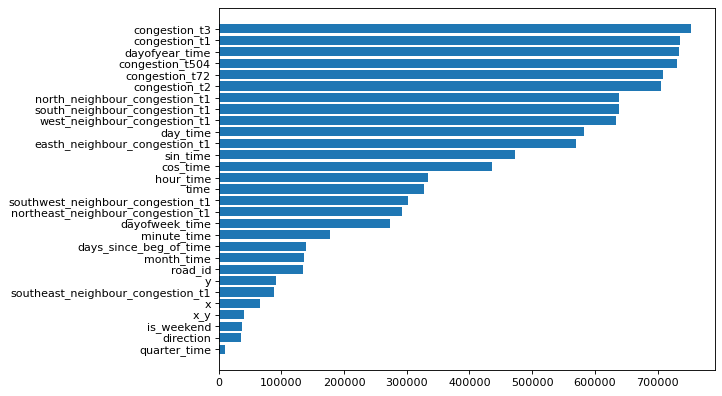

In [618]:
featureimportancedf = pd.DataFrame(automl.model.estimator.feature_name_, columns=['feature_name'])
featureimportancedf['feature_importance'] = automl.model.estimator.feature_importances_
featureimportancedf.sort_values('feature_importance', ascending=True, inplace=True)
featureimportancedf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.barh(featureimportancedf['feature_name'], featureimportancedf['feature_importance'])

In [414]:
#import xgboost
#xgboost.__version__



'1.3.3'

In [430]:
automl.model.estimator.feature_names_in_

AttributeError: 'ExtraTreesRegressor' object has no attribute 'feature_names_in_'

In [428]:
len(features)

24

In [447]:
len(automl.model.estimator.feature_importances_)

19